In [25]:
import os

import pandas as pd

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

from util import util
from dataloader.original import get_dataset, preprocessor
from torch.utils.data import DataLoader
import torch
from architecture import pipe
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from dataloader.original import get_dataset
from architecture.LitViT import LitViT
from tqdm import tqdm
from torchvision.transforms.v2 import functional as F

In [26]:
parser = util.LabelParser()

In [27]:
dataset = DataLoader(get_dataset('test', augmentation=False), batch_size=1, shuffle=False, pin_memory=True)

In [28]:
model = pipe.get_model().to('cpu')
model

LitViT(
  (vit): SimpleViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=768, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (transformer): Transformer(
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Linear(in_features=1024, out_features=1024, bias=False)
          )
          (1): FeedForward(
            (net): Sequential(
              (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (1): Linear(in_features=1024, out_feature

In [93]:
vit = LitViT.load_from_checkpoint('./logs/copy.ckpt', vit=model.vit).cuda()

In [94]:
logits = []
for data in tqdm(dataset):
    x, y = data
    
    logits.append(vit(preprocessor(x.cuda())).cpu().detach().numpy())

100%|██████████| 5213/5213 [01:05<00:00, 79.48it/s]


In [95]:
logits = np.stack(logits)

In [96]:
logits.shape

(5213, 1, 33)

In [97]:
logits = logits.transpose(1,0,2).squeeze()

In [98]:
logits

array([[ 0.09533975, -0.30254325,  1.2362722 , ..., -1.1698793 ,
        -0.22760361, -0.54225403],
       [ 0.35610846, -0.9265015 ,  0.6812962 , ..., -2.5803654 ,
         0.95536715,  0.7523564 ],
       [-0.05672107,  0.21651363,  0.8478981 , ..., -0.07857075,
        -0.2105759 , -1.0692842 ],
       ...,
       [-0.14720316, -0.28315938,  0.5999862 , ..., -1.1229513 ,
         1.3083638 , -0.5000695 ],
       [-0.61589026, -0.39029816,  0.6546199 , ..., -0.84608173,
        -0.03007097,  0.04853676],
       [ 0.47311175, -0.6404068 ,  0.72066784, ..., -2.0679011 ,
         0.7344242 ,  0.2329428 ]], dtype=float32)

In [99]:
pca_decomposer = PCA(n_components=3)

In [100]:
pca_vectors = pca_decomposer.fit_transform(logits)

In [101]:
np.max(pca_vectors), np.min(pca_vectors)

(5.325655, -3.2465756)

D:\ml\mtest\learn_env\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


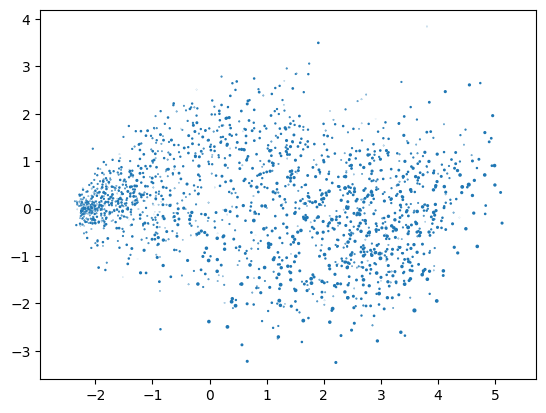

In [102]:
# make a 3d plot

plt.scatter(pca_vectors[:,0], pca_vectors[:,1], pca_vectors[:,2])

In [103]:
tsne_decomposer = TSNE(n_components=3, n_iter=10000, perplexity=500)

In [104]:
tsne_vectors = tsne_decomposer.fit_transform(logits)

In [105]:
np.max(tsne_vectors), np.min(tsne_vectors)

(9.642343, -9.037847)

In [106]:
np.mean(tsne_vectors, axis=0), np.std(tsne_vectors, axis=0)

(array([ 0.29622975, -0.09358709,  0.10507724], dtype=float32),
 array([5.3636246, 1.2494051, 1.5361054], dtype=float32))

D:\ml\mtest\learn_env\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


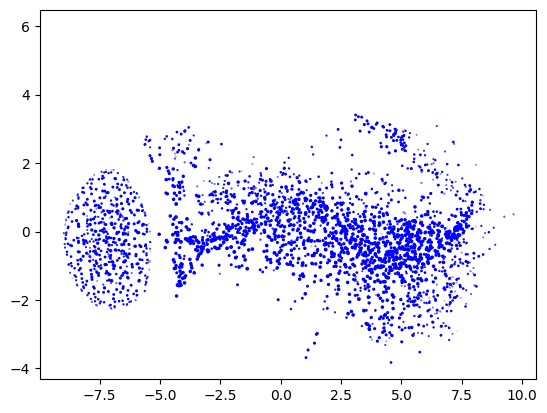

In [107]:
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], tsne_vectors[:, 2], c='blue')

In [108]:
pd.DataFrame(pca_vectors, columns = ['x', 'y', 'z']).to_json('pca_vectors.json')

In [109]:
pd.DataFrame(tsne_vectors, columns = ['x', 'y', 'z']).to_json('tsne_vectors.json')